# Assignment 3: Simulated Annealing
---

Kazybek Askarbek, BS18-DS01



The goal for this homework is to implement an optimization algorithm called
Simulated Annealing (SA). It is based on sampling and the optimization pro-
cedure is similar to the Metropolis-Hastings (MH) algorithm. Because the op-
timization is based on sampling, SA allows to optimize even non-differentiable
functions, and thus it is applicable to optimizing combinatorial problems.

## Download the data

In [1]:
!wget https://raw.githubusercontent.com/hflabs/city/master/city.csv -O city.csv

--2022-04-24 13:04:16--  https://raw.githubusercontent.com/hflabs/city/master/city.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324179 (317K) [text/plain]
Saving to: ‘city.csv’

city.csv            100%[===================>] 316.58K  --.-KB/s    in 0.03s   

2022-04-24 13:04:16 (9.53 MB/s) - ‘city.csv’ saved [324179/324179]



## Simulated Annealing

Find the optimal traveling salesman path using SA for 30 most populated
cities (remember that the dataset contains geodesic coordinates, calculating
the distance would require to apply a suitable transformation);

In [2]:
# standard libraries
from functools import partial
# third party packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import distance as geo_dist

In [3]:
def get_lat_lan(id):
    record = df.loc[id]
    return record['geo_lat'], record['geo_lon']


def calc_intercity_dist(city_a_id, city_b_id):
    point_a = get_lat_lan(city_a_id)
    point_b = get_lat_lan(city_b_id)
    
    return geo_dist(point_a, point_b).km


def calc_path_length(path):
    total = 0
    ids = list(path.values())
    for city_a_id, city_b_id in zip(ids, ids[1:]):
        distance = calc_intercity_dist(city_a_id, city_b_id)
        total += distance
    return round(total)

In [4]:
def gen_new_path(path):
    # pick two cities in the path
    positions = list(path.keys())
    p1, p2 = np.random.choice(positions, 2)
    # exchange their positions in the path
    new_path = path.copy()
    new_path[p1] = path[p2]
    new_path[p2] = path[p1]
    # return new path
    return new_path


# exponential decay
def new_T(T, alpha):
    assert alpha < 1, 'Alpha should be less than 1'

    return T * alpha
    

def p_star(path, T):
    return np.e ** (- calc_path_length(path) / T)

In [5]:
def simulated_annealing(indices, T=100, T_min_threshold=0.0001, T_alpha=0.9, N=10):
    """Function to find the shorted path using Simulated Annealing

        Arguments:
            indices - indices of the cities
            T - initial temperature
            T_min_threshold - minimal temperature
            T_alpha - decay factor
            N - temperature update period
    """
    temp_bucket = []
    cost_bucket = []
    iter_bucket = []
    path_bucket = []

    
    # shuffle indices
    np.random.shuffle(indices)

    # fill in the initial path dict
    path = {i: index for i, index  in enumerate(indices)}
    # set time to 0
    t = 0
    # while temperature is not cooled down
    while T > T_min_threshold:
        # generate x_hat from g(x_hat | x_t)
        x_hat = gen_new_path(path)

        # calculate acceptance ratio
        try:
            alpha = p_star(x_hat, T) / p_star(path, T)
        except:
            return {
                    'path': path,
                    't': t,
                    'T': T,
                    'temp_bucket': temp_bucket,
                    'cost_bucket': cost_bucket,
                    'iter_bucket': iter_bucket,
                    'path_bucket': path_bucket,
                    }

        # update only if u is less or equal to alpha
        u = np.random.random()
        if u <= alpha:
            path = x_hat

        # reduce temperature every N iterations
        if t % N == 0:
            temp_bucket.append(T)
            cost_bucket.append(calc_path_length(path))
            iter_bucket.append(t)
            path_bucket.append(path)

            T = new_T(T, T_alpha)
        # update time
        t += 1
    
    return {
        'path': path,
        't': t,
        'T': T,
        'temp_bucket': temp_bucket,
        'cost_bucket': cost_bucket,
        'iter_bucket': iter_bucket,
        'path_bucket': path_bucket,
        }

In [6]:
df = pd.read_csv('city.csv')
# select top 30 cities sorted by max population
top30_cities = df.sort_values('population', ascending=False).head(30)

# get city indices
indices = list(top30_cities.index)

In [7]:
%%time

T = 1000
T_min_threshold = 0.01
N = 15
T_alpha = 0.9

output = simulated_annealing(indices, T, T_min_threshold, T_alpha, N)

CPU times: user 26.4 s, sys: 74.8 ms, total: 26.5 s
Wall time: 31.5 s


In [8]:
distance = calc_path_length(output['path'])

print(f"Found path is {distance} km.\nIterations: {output['t']}\nTemperature: {round(output['T'], 2)}")

Found path is 24126 km.
Iterations: 481
Temperature: 30.9


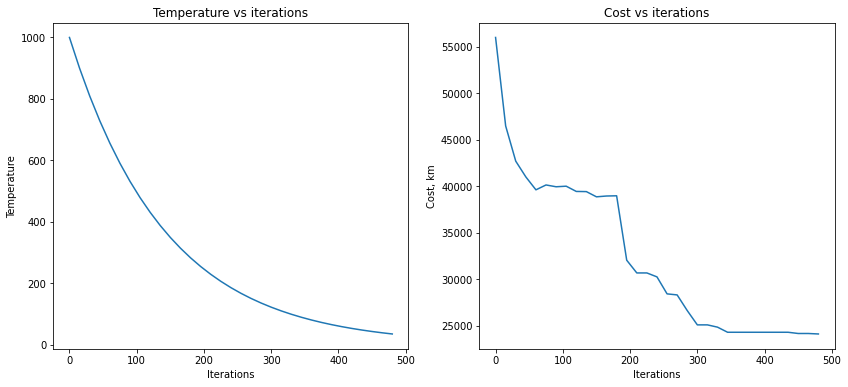

In [9]:
temp_bucket = output['temp_bucket']
cost_bucket = output['cost_bucket']
iter_bucket = output['iter_bucket']
path_bucket = output['path_bucket']


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


ax1.plot(iter_bucket, temp_bucket)

ax1.set_title('Temperature vs iterations')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Temperature')


ax2.plot(iter_bucket, cost_bucket)

ax2.set_title('Cost vs iterations')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Cost, km')

plt.show()

## Visualizations


Produce a visualization of your optimization process. Use documentation
as a guideline.



In [10]:
import plotly.express as px
import plotly.graph_objects as go


def get_path_info(path, df):
    ids = list(path.values())
    
    lats = list(df.loc[ids]['geo_lat'])
    lons = list(df.loc[ids]['geo_lon'])
    names = list(df.loc[ids]['address'])

    return lats, lons, names


def visualize_path(path):
    lats, lons, names = get_path_info(path, top30_cities)


    # fig = px.line_geo(lat=lats, lon=lons, hover_name=names, labels=names, markers=True, title='sss')


    fig = go.Figure(go.Scattermapbox(
        mode = "markers+lines+text",
        lon = lons,
        lat = lats,
        marker = {'size': 10},
        text=names,
        ))


    fig.update_layout(
        margin ={'l':0,'t':0,'b':0,'r':0},
        mapbox = {
            'center': {'lon': 0, 'lat': 10},
            'style': "stamen-terrain",
            'center': {'lon': 80, 'lat': 50},
            'zoom': 3})

    fig.show()

In [11]:
visualize_path(output['path'])

## Experiments
For your selected annealing schedule, track the speed of convergence for
three different values of the annealing rate (try fast cooling, slow cooling,
and some middle value). Compare the optimization result;

### Fast annealing rate

In [12]:
%%time

T = 1000
T_min_threshold = 0.01
N = 15
T_alpha = 0.5

output = simulated_annealing(indices, T, T_min_threshold, T_alpha, N)

CPU times: user 2.62 s, sys: 13 ms, total: 2.63 s
Wall time: 2.63 s


In [13]:
distance = calc_path_length(output['path'])

print(f"Found path is {distance} km.\nIterations: {output['t']}\nTemperature: {round(output['T'], 2)}")

Found path is 43115 km.
Iterations: 61
Temperature: 31.25


In [14]:
visualize_path(output['path'])

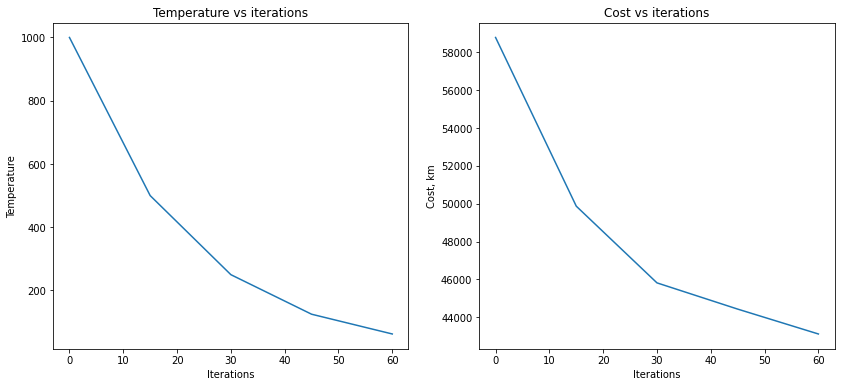

In [15]:
temp_bucket = output['temp_bucket']
cost_bucket = output['cost_bucket']
iter_bucket = output['iter_bucket']
path_bucket = output['path_bucket']


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


ax1.plot(iter_bucket, temp_bucket)

ax1.set_title('Temperature vs iterations')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Temperature')


ax2.plot(iter_bucket, cost_bucket)

ax2.set_title('Cost vs iterations')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Cost, km')

plt.show()

### Middle annealing rate

In [16]:
%%time


T = 1000
T_alpha = 0.8

T_min_threshold = 0.01

N = 20

output = simulated_annealing(indices, T, T_min_threshold, T_alpha, N)

CPU times: user 11.4 s, sys: 37 ms, total: 11.5 s
Wall time: 11.5 s


In [17]:
distance = calc_path_length(output['path'])

print(f"Found path is {distance} km.\nIterations: {output['t']}\nTemperature: {round(output['T'], 2)}")

Found path is 27186 km.
Iterations: 281
Temperature: 35.18


In [18]:
visualize_path(output['path'])

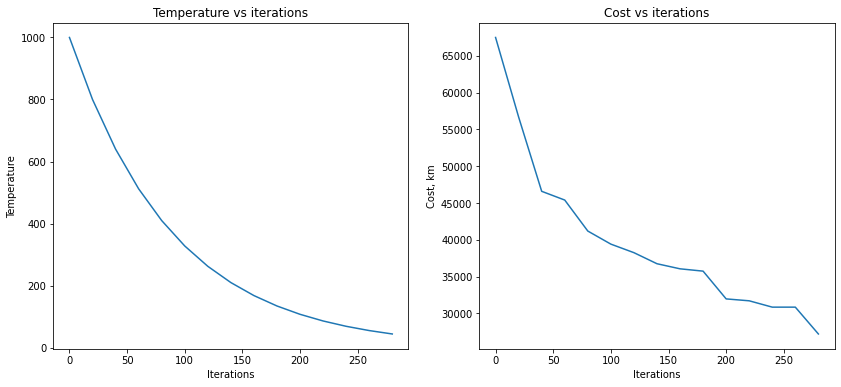

In [19]:
temp_bucket = output['temp_bucket']
cost_bucket = output['cost_bucket']
iter_bucket = output['iter_bucket']
path_bucket = output['path_bucket']


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


ax1.plot(iter_bucket, temp_bucket)

ax1.set_title('Temperature vs iterations')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Temperature')


ax2.plot(iter_bucket, cost_bucket)

ax2.set_title('Cost vs iterations')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Cost, km')

plt.show()

### Slow annealing rate

In [20]:
%%time


T = 1000
T_min_threshold = 0.01
N = 100
T_alpha = 0.95  # 99

output = simulated_annealing(indices, T, T_min_threshold, T_alpha, N)

CPU times: user 4min 55s, sys: 646 ms, total: 4min 55s
Wall time: 4min 57s


In [21]:
distance = calc_path_length(output['path'])

print(f"Found path is {distance} km.\nIterations: {output['t']}\nTemperature: {round(output['T'], 2)}")

Found path is 15342 km.
Iterations: 7501
Temperature: 20.28


In [22]:
visualize_path(output['path'])

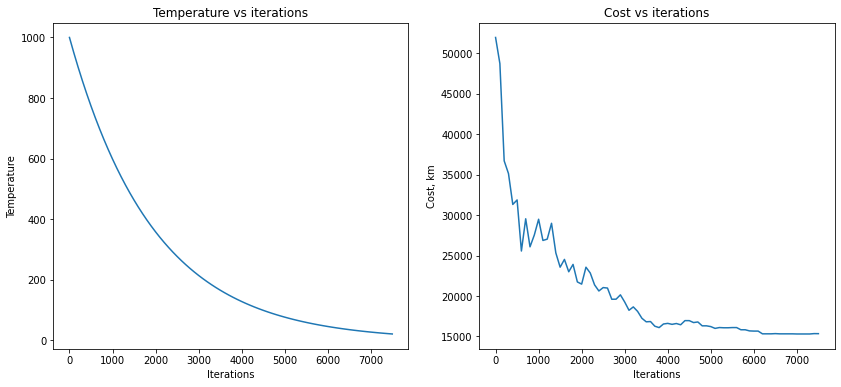

In [23]:
temp_bucket = output['temp_bucket']
cost_bucket = output['cost_bucket']
iter_bucket = output['iter_bucket']
path_bucket = output['path_bucket']


_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


ax1.plot(iter_bucket, temp_bucket)

ax1.set_title('Temperature vs iterations')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Temperature')


ax2.plot(iter_bucket, cost_bucket)

ax2.set_title('Cost vs iterations')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Cost, km')

plt.show()

## Report

This notebook has considered a simulated annealing algorithm for the problem of traveling salesman.


It is obvious from our experiments that Fast set up(where the annealing factor is close to 0) converges in fewer iterations but with poorer results in terms of overall distance. Middle set up(where the annealing factor in between 0 and 1) converges 2-5 times longer, but produces better results. Slow set up(where the annealing factor is close to 1) the amount of iterations is significantly larger, however the final cost is less for about 8000 km.

---

Link to the Github Repository

Link to the Telegram: @qazybi